# Introduction

For many machine learning algorithms, the particular representation of the data that you provide is very important. This starts with scaling the data and combining features by hand and goes all the way to learning features using unsupervised machine learning. Consequently, most machine learning applications require not only the application of a single algorithm, but the chaining together of many different processing steps and machine learning models. In this chapter, we will cover how to use the Pipeline class to simplify the process of building chains of transformations and models. In particular, we will see how we can combine Pipeline and GridSearchCV to search over parameters for all processing steps at once.

As an example of the importance of chaining models, we noticed that we can greatly improve the performance of a kernel SVM on the cancer dataset by using the Min MaxScaler for preprocessing. Here’s code for splitting the data, computing the minimum and maximum, scaling the data, and training the SVM:


In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
# load data
cancer=load_breast_cancer()
# Split the data
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=0)

# Compute minimum and maximum on the training data
scaler=MinMaxScaler().fit(X_train)

# rescale training data 
X_train_scaled=scaler.transform(X_train)

In [5]:
svm=SVC()
# fit the scaled train data into svm
svm.fit(X_train_scaled,y_train)

#scale test data and score it
X_test_scaled=scaler.transform(X_test)

print("Test score: {:.2f}".format(svm.score(X_test_scaled,y_test)))

Test score: 0.95


# Parameter selection with Preprocessing

Now let’s say we want to find better parameters for SVC using GridSearchCV. How should we go about doing this? A naive approach might look like this:


In [6]:
from sklearn.model_selection import GridSearchCV

# for illustration purpose only, don't use this code
param_grid={'C':[0.001,0.01,0.1,1,10,100],
           'gamma':[0.001,0.01,0.1,1,10,100]}
grid=GridSearchCV(SVC(),param_grid=param_grid,cv=5)
grid.fit(X_train_scaled,y_train)
print("Best cross validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled,y_test)))
print("Best parameters: ",grid.best_params_)

Best cross validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


Here, we ran the grid search over the parameters of SVC using the scaled data. However, there is a subtle catch in what we just did. When scaling the data, we used all the data in the training set to find out how to train it. We then use the scaled training data to run our grid search using cross-validation. For each split in the cross-validation, some part of the original training set will be declared the training part of the split, and some the test part of the split. The test part is used to measure what new data will look like to a model trained on the training part. However, we already used the information contained in the test part of the split, when scaling the data. Remember that the test part in each split in the cross-validation is part of the training set, and we used the information from the entire training set to find the right scaling of the data.

This is fundamentally different from how new data looks to the model. If we observe new data (say, in form of our test set), this data will not have been used to scale the training data, and it might have a different minimum and maximum than the training data. The following example shows how the data processing during cross-validation and the final evaluation differ:

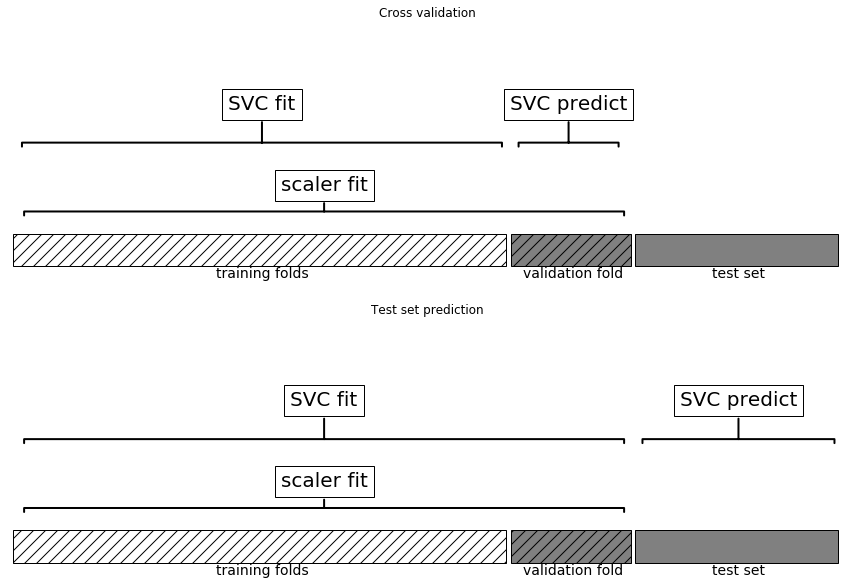

In [9]:
import mglearn
mglearn.plots.plot_improper_processing()

So, the splits in the cross-validation no longer correctly mirror how new data will look to the modeling process. We already leaked information from these parts of the data into our modeling process. This will lead to overly optimistic results during cross-validation, and possibly the selection of suboptimal parameters. 

To get around this problem, the splitting of the dataset during cross-validation should be done before doing any preprocessing. Any process that extracts knowledge from the dataset should only ever be applied to the training portion of the dataset, so any cross-validation should be the “outermost loop” in your processing.

To achieve this in scikit-learn with the cross_val_score function and the Grid SearchCV function, we can use the Pipeline class. The Pipeline class is a class that allows “gluing” together multiple processing steps into a single scikit-learn estimator.  The Pipeline class itself has fit, predict, and score methods and behaves just like any other model in scikit-learn. The most common use case of the Pipeline class is in chaining preprocessing steps (like scaling of the data) together with a supervised model like a classifier. 

In [12]:
from sklearn.pipeline import Pipeline
pipe=Pipeline([("scaler",MinMaxScaler()),("svm",SVC(probability=True))])

Here, we created two steps: the first, called "scaler", is an instance of MinMaxScaler, and the second, called "svm", is an instance of SVC. Now, we can fit the pipeline, like any other scikit-learn estimator:

In [13]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Here, pipe.fit first calls fit on the first step (the scaler), then transforms the training data using the scaler, and finally fits the SVM with the scaled data. To evaluate on the test data, we simply call pipe.score:


In [14]:
print("Test score: {:.2f}".format(pipe.score(X_test,y_test)))

Test score: 0.95


Calling the score method on the pipeline first transforms the test data using the scaler, and then calls the score method on the SVM using the scaled test data. As you can see, the result is identical to the one we got from the code at the beginning of the chapter, when doing the transformations by hand. Using the pipeline, we reduced the code needed for our “preprocessing + classification” process. The main benefit of using the pipeline, however, is that we can now use this single estimator in cross_val_score or GridSearchCV.


# Using Pipelines in Grid Searchs

Using a pipeline in a grid search works the same way as using any other estimator. We define a parameter grid to search over, and construct a GridSearchCV from the pipeline and the parameter grid. When specifying the parameter grid, there is a slight change, though. We need to specify for each parameter which step of the pipeline it belongs to. Both parameters that we want to adjust, C and gamma, are parameters of SVC, the second step. We gave this step the name "svm". The syntax to define a parameter grid for a pipeline is to specify for each parameter the step name, followed by __ (a double underscore), followed by the parameter name. To search over the C parameter of SVC we therefore have to use "svm__C" as the key in the parameter grid dictionary, and similarly for gamma:


In [15]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]} 

grid=GridSearchCV(pipe,param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))


Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


In contrast to the grid search we did before, now for each split in the cross-validation, the MinMaxScaler is refit with only the training splits and no information is leaked from the test split into the parameter search.

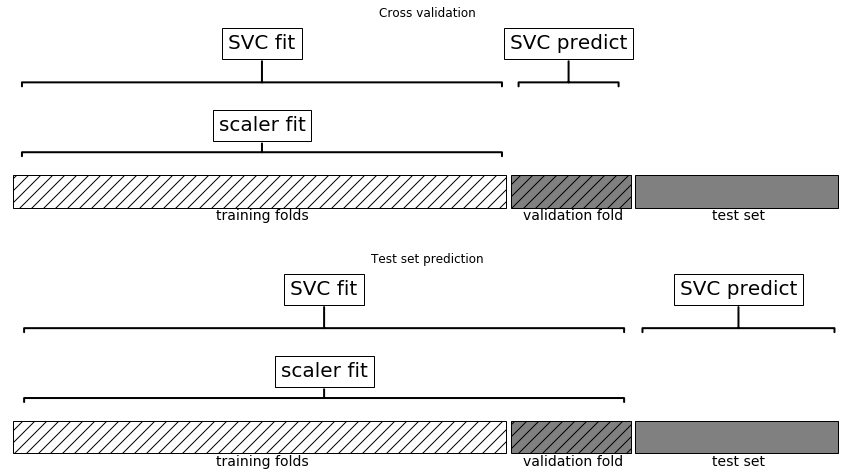

In [16]:
mglearn.plots.plot_proper_processing()